In [ ]:
%pylab inline

In [ ]:
from scipy.optimize import minimize
from numdifftools import Hessian
from math import ceil
import warnings
from tqdm import tqdm_notebook
warnings.filterwarnings("ignore")
numpy.set_printoptions(precision=4)

In [ ]:
cd Measurement-automation/

In [ ]:
from lib2.fulaut.qubit_spectra import transmon_spectrum
from lib2.fulaut.AnticrossingOracle import AnticrossingOracle

In [154]:
def gauss_model(X, a, missing_values = None):
    return ones_like(X)*a

def linear_model(X, a, b, missing_values = None):
    return a*X+b

def square_model(X, a, b, c, missing_values = None):
    return a*X**2+b*X+c

def sin_model(X, a, b, c, missing_values = None):
    return a*sin(X*b+c)

def exp_model(X, a, b, c, missing_values = None):
    return a*exp(-b*X)+c

def transmon_model(X, f_r, g, period, sws, max_q_freq, d, missing_values = nan):
    
    f_qs = transmon_spectrum(X, period, sws, max_q_freq, d)
    levels = AnticrossingOracle._eigenlevels(f_qs, f_r, g)
    
    upper_limit = f_r + freq_window
    lower_limit = f_r - freq_window

    res_freqs_model = ones_like(X)*missing_values
    idcs1 = where(logical_and(lower_limit < levels[1, :],
                              levels[1, :] < upper_limit))
    idcs2 = where(logical_and(lower_limit < levels[2, :],
                              levels[2, :] < upper_limit))

    res_freqs_model[idcs1] = levels[1, :][idcs1]
    res_freqs_model[idcs2] = levels[2, :][idcs2]
    
    return res_freqs_model

In [ ]:
def add_noise(data, sigma, seed = True):
    if seed:
        return data + random.RandomState(1).normal(scale = sigma, size=data.shape)
    else:
        return data + random.normal(scale = sigma, size=data.shape)

In [ ]:
def loss_function(params, model_name, X, Y, verbose = False):
    M = models[model_name](X, *params, missing_values = params[0])
    residuals = (Y - M)
#     nonnan_len = len(residuals[~isnan(residuals)])
#     print(nonnan_len)
    return sum((residuals)**2)/2
    
def find_param_scales(model_name, X, Y, opt_params):
    opt_loss = loss_function(opt_params, model_name, X, Y)
    threshold_loss_change = sigma**2
    scales = []
    for i in range(len(opt_params)):
        for absolute_parameter_change in logspace(-16, 16, 66*10):
            test_params = opt_params.copy()
            test_params[i] = test_params[i] + absolute_parameter_change
            test_loss = loss_function(test_params, model_name, X, Y)
            loss_change = test_loss - opt_loss
            
#             print(i, absolute_parameter_change, loss_change)
            
            if loss_change >= threshold_loss_change:
                scales.append(absolute_parameter_change)
                break
    return array(scales)

def plot_loss(model_name, X, Y, opt_params, scale = 1):
    hess = hessian(model_name, X, Y, opt_params)
    scales = scale*sigma*1/sqrt(diag(hess))
#     scales = scale * find_param_scales(model_name, X, Y, opt_params)
    
    param_arrays = []
    for idx, param in enumerate(opt_params):
        param_arrays.append(linspace(param - scales[idx], param+scales[idx], 100))
        
    def calculate_loss(arr1, arr2, idx1, idx2):
        loss = []
        for p1 in arr1:
            row = []
            for p2 in arr2:
                test_params = opt_params.copy()
                test_params[idx1] = p1
                test_params[idx2] = p2
                row.append(loss_function(test_params, model_name, X, Y))
            loss.append(row)
        return array(loss)
    
    plot_number = int(len(opt_params)*(len(opt_params)-1)/2)
    
    ncols = 5 if plot_number > 5 else plot_number
    nrows = ceil(plot_number/5)
    
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=(5*ncols, 5*nrows))
    axes = axes.ravel()
    axes_idx = 0
    for idx1, param_array1 in tqdm_notebook(enumerate(param_arrays[:-1])):
        for idx2, param_array2 in enumerate(param_arrays[idx1+1:]):
            p1_num = idx1
            p2_num = idx1+1+idx2
            loss_data = (calculate_loss(param_array1, param_array2, p1_num, p2_num))
            axes[axes_idx].contour(param_array1, param_array2, loss_data.T, 50, cmap="Spectral_r")
            axes[axes_idx].set_title(param_names[model_name][p2_num]+" vs "+param_names[model_name][p1_num])
            axes[axes_idx].set_ylabel(param_names[model_name][p2_num])
            axes[axes_idx].set_xlabel(param_names[model_name][p1_num])
            axes[axes_idx].xaxis.set_tick_params(rotation=20)
            axes_idx += 1
    plt.tight_layout()


def hessian(model_name, X, Y, opt_params, scales = None):
    if scales is None:
        scales = array(find_param_scales(model_name, X, Y, opt_params))
    hess = Hessian(loss_function, step = scales)
    return hess(opt_params, model_name, X, Y)

In [ ]:
def fit(model_name, X, data):
    args = (model_name, X, data)
    x0 = array(params[model_name]).copy()
    for idx in range(len(x0)):
        x0[idx] *= random.RandomState(1).normal(loc=1, scale=0.0001)

    return minimize(loss_function, x0, args = args, method = "Nelder-Mead")

def estimate_sigma(model_name, X, Y, opt_params):
    return sqrt(2*loss_function(opt_params, model_name, X, Y)/(len(X)-len(params[model_name])))

In [158]:
a, b, c = 3, 10, 1
models = {"gau":gauss_model, "lin":linear_model, "sq":square_model, "sin":sin_model, "exp":exp_model, "tr":transmon_model}
params = {"gau":(0,), "lin":(a,b), "sq":(a*10,b,c), "sin":(a,b,c), "exp":(a,b,c), "tr":(6, 0.05, 0.7, 0.4, 7, 0.5)}
param_names = {"gau":(r"$\sigma$", ), "lin":("a", "b"),"sq":("a", "b", "c"), 
               "sin":("A", r"$\omega$", r"$\phi$"), "exp":("A", r"$\gamma$", "C"),
               "tr":("$f_r$", "$g$", "$\Pi$", "$I_{ss}$", "$f_q^{max}$", "$d$")}

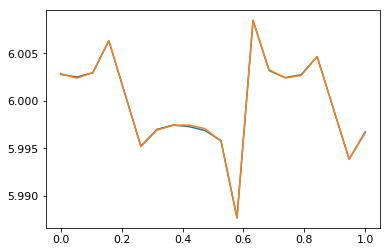

In [235]:
X = linspace(0,1, 20)
freq_window = 0.02
sigma = 0.0001
use_mask = False
model_name = "tr"
true_data = models[model_name](X, *params[model_name])
freq_window = .1
X = X[~isnan(true_data)]
true_data = true_data[~isnan(true_data)]
noisy_data = add_noise(true_data, sigma, seed = False)

result = fit(model_name, X, noisy_data)
test_params = result.x.copy()
# test_params[1] = 0.2
# test_params[0]*=1.001

fit_data = models[model_name](X, *test_params)

scales = find_param_scales(model_name, X, noisy_data, result.x)
scales

plot(X, noisy_data)
plot(X, fit_data)

In [236]:
sqrt(result.fun * 2/len(X)), estimate_sigma(model_name, X, noisy_data, result.x)

(8.557990350658793e-05, 0.00010481354791388064)

In [ ]:
result.x, result.x - array(params[model_name])

In [ ]:
losses = []
test_params = result.x.copy()
# test_params[1] = 0
idx = 0
factor = 10
p_vals = linspace(result.x[idx]-scales[idx]*factor, result.x[idx]+scales[idx]*factor, 1000)
for p1 in p_vals:
    test_params[idx] = p1
    loss = loss_function(test_params, model_name, X, noisy_data)
    losses.append(loss)

In [ ]:
plot(p_vals, losses)
xticks(rotation=20);

In [ ]:
test_params = result.x.copy()
test_params[0]*=1.00000
fit_data = models[model_name](X, *test_params, test_params[0])

test_params[0], sum((noisy_data - fit_data)**2)/2

In [ ]:
plot(X, (noisy_data - fit_data)**2)

In [ ]:
plot(X, true_data, ".")
plot(X, noisy_data, ".")
plot(X, fit_data, ".")
# plt.ylim(5.99, 6.01)
plt.grid()

In [ ]:
hess = hessian(model_name, X, noisy_data, result.x)
hess, 1/sqrt(diag(hess)), sqrt(diag(inv(hess)))

array([2.2490e-01, 3.3744e+00, 2.6687e+00, 1.3286e+00, 9.5944e+01, 2.7482e+02]))

array([2.2243e-01, 3.1117e+00, 2.6952e+00, 1.3441e+00, 8.7480e+01, 2.9580e+02]))

array([1.9483e-01, 2.4486e+00, 2.6809e+00, 1.3229e+00, 6.7947e+01, 2.4691e+02]))

array([2.6425e-01, 3.6389e+00, 4.7909e+00, 2.3712e+00, 9.7922e+01, 2.9823e+02]))

array([2.5432e-01, 3.2805e+00, 4.7827e+00, 2.3603e+00, 8.7370e+01, 2.9681e+02]))

array([2.5830e-01, 3.3495e+00, 4.7824e+00, 2.3880e+00, 8.9222e+01, 3.1076e+02]))

array([2.5991e-01, 3.3787e+00, 4.7643e+00, 2.3661e+00, 8.9932e+01, 3.0918e+02]))

In [193]:
estimate_sigma(model_name, X, noisy_data, result.x)

0.00010005645800415842

In [ ]:
sqrt(diag(inv(hess)))*estimate_sigma(model_name, X, noisy_data, result.x)

In [ ]:
plot_loss(model_name, X, noisy_data, result.x, 100)
plt.savefig("../Pictures/loss.pdf", bbox_inches="tight")
# plt.gcf().set_size_inches(7,7)

## Собственно, тест

In [194]:
def fit_random(X, return_hess = True):
    global freq_window
    freq_window = 0.02
    true_data = models[model_name](X, *params[model_name])
    freq_window = 0.1

    X_nonnan = X[~isnan(true_data)]
    true_data = true_data[~isnan(true_data)]
    noisy_data = add_noise(true_data, sigma, seed = False)
    result = fit(model_name, X_nonnan, noisy_data)
    if return_hess:
        hess = hessian(model_name, X_nonnan, noisy_data, result.x, scales)
        return X_nonnan, noisy_data, result, hess
    else:
        return X_nonnan, noisy_data, result

def set_scales():
    global X
    X = linspace(0, 1, NOP)
    X_nonnan, noisy_data, result = fit_random(X, False)
    global scales
    scales = find_param_scales(model_name, X_nonnan, noisy_data, result.x)

def monte_carlo_test():
    results = []
    hessians = []
    chi_sq = []
    
    for i in tqdm_notebook(range(MC_ITER)):
        X_nonnan, noisy_data, result, hess = fit_random(X)
        results.append(result.x)
        hessians.append(hess)
        chi_sq.append(estimate_sigma(model_name, X_nonnan, noisy_data, result.x))
    return array(results), hessians, chi_sq

def compare(results, verbose=False):
    exp_var = var(results, axis=0, ddof=results.shape[1])
    exp_cov = cov(results.T, ddof=results.shape[1])
    
    X_nonnan, noisy_data, result, hess = fit_random(X)
    fit_data = models[model_name](X_nonnan, *result.x)
    
    plot(X_nonnan, noisy_data)
    plot(X_nonnan, fit_data)

    hess = hessian(model_name, X_nonnan, noisy_data, result.x)
#     hess_sigma = sqrt(diag(inv(hess)))*estimate_sigma(model_name, X_nonnan, noisy_data, result.x)
    hess_var = diag(inv(hess))*sigma**2

#     hess_cov = inv(hess)*estimate_sigma(model_name, X_nonnan, noisy_data, result.x)**2
    hess_cov = inv(hess)*sigma**2
    
#     print(exp_var-hess_var, exp_cov-hess_cov)
    
    if verbose:
        print(result.x, "\n", hess, "\n", hess_cov, "\n", exp_cov)
    print("Var error, %:")
    print((exp_var-hess_var)/exp_var*100)
    print("Cov error, %:")
    print((exp_cov-hess_cov)/abs(exp_cov)*100)
    

def plot_convergence(results):
    results = (results - mean(results, 0))
    means = abs(cumsum(results, 0).T/linspace(1, len(results), len(results)))
    plot(means.T)
    plt.gcf().set_size_inches(10,1)
    yscale("log")

def plot_hist(results):
    n_plots = results.shape[1]
    nrows = ceil(n_plots/3)
    ncols = n_plots if n_plots <= 3 else 3
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=(5*ncols, 2.5*nrows))
    axes = axes.ravel()
    for i in range(results.shape[1]):
        axes[i].hist(results[:,i], 100, color="C%d"%i)
#         axes[i].set_yscale("log")
        axes[i].set_ylabel("Counts")
        axes[i].set_xlabel(param_names[model_name][i])
        axes[i].xaxis.set_tick_params(rotation=20)
    plt.tight_layout()

def hessian_var_hist(hessians, results, analytic_hess = None):
    exp_var = var(results, axis=0, ddof=results.shape[1]).T

    variances = []
    for hess in hessians:
        variances.append(diag(inv(hess))*sigma**2)
    variances = array(variances)
    analytic_variances = diag(inv(analytic_hess))*sigma**2
    
    n_plots = variances.shape[1]
    nrows = ceil(n_plots/3)
    ncols = n_plots if n_plots <= 3 else 3
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=(5*ncols, 2.5*nrows))
    axes = axes.ravel()
    for idx, variance_arr in enumerate(variances.T):
#         print(mean(variance_arr))
        variance_arr_no_outliers = variance_arr[abs(variance_arr - np.mean(variance_arr)) < 3 * np.std(variance_arr)]
        axes[idx].hist(variance_arr_no_outliers, len(hessians)//100, color="C%d"%idx)
        axes[idx].plot([mean(variance_arr)]*2, [0, 200], "--x", color = "C%d"%idx, label="Mean Hessian var")
        axes[idx].plot([exp_var[idx]]*2, [0, 200], "-x", color="red", label="Experimental var")
#         axes[idx].set_yscale("log")
        axes[idx].set_title(param_names[model_name][idx])
        axes[idx].set_ylabel("Counts")
        axes[idx].set_xlabel("$H_{ii}$ value")
        if analytic_hess is not None:
            axes[idx].plot([analytic_variances[idx]]*2, [0, 200], "-*", color="red", label="Analytic Hessian var")
    
        axes[idx].xaxis.set_tick_params(rotation=20)
#         axes[idx].set_xlim(mean(variance_arr), exp_var[idx])
    axes[0].legend()
    plt.tight_layout()

### Относительная ошибка в дисперсиях-ковариациях

In [ ]:
numpy.set_printoptions(precision=4)

In [ ]:
MC_ITER = 5000
NOP = 1001

In [ ]:
sigma = .1
model_name = "gau"
set_scales()
# results_gau, hessians_gau = monte_carlo_test()
compare(results_gau, True)

In [ ]:
plot_convergence(results_gau); figure(); plot_hist(results_gau); figure(); hessian_var_hist(hessians_gau, results_gau)

In [114]:
sum([1/2*2 for x in X])

1001.0

In [116]:
hessians_lin

[array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.5   ],
        [ 500.5   , 1001.    ]]), array([[ 333.8335,  500.


Var error, %:
[3.1031 2.7107]
Cov error, %:
[[ 3.1031 -3.1798]
 [-3.1798  2.7107]]


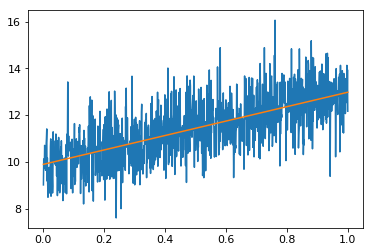

In [105]:
sigma = 1
use_mask = False
model_name = "lin"
set_scales()
results_lin, hessians_lin = monte_carlo_test()
compare(results_lin, )

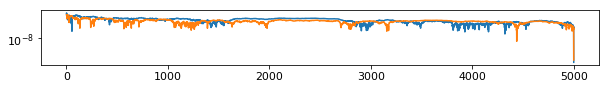

<Figure size 432x288 with 0 Axes>

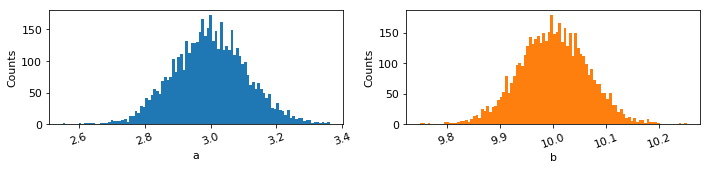

<Figure size 432x288 with 0 Axes>

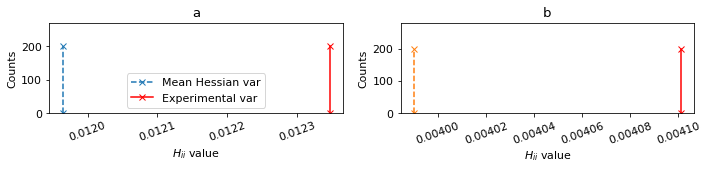

In [106]:
plot_convergence(results_lin); figure(); plot_hist(results_lin); figure(); hessian_var_hist(hessians_lin, results_lin)

In [ ]:
sigma = 0.1
use_mask = False
model_name = "sq"
set_scales()
# results_sq, hessians_sq = monte_carlo_test()
compare(results_sq)

In [ ]:
plot_convergence(results_sq); figure(); plot_hist(results_sq); figure(); hessian_var_hist(hessians_sq, results_sq)

In [119]:
a,b,c

(3, 10, 1)

In [122]:
mean(array(hessians_sin), axis=0)

array([[ 523.8073,   71.5444,   44.4599],
       [  71.5444, 1476.5301, 2241.4263],
       [  44.4599, 2241.4263, 4294.7163]])

Var error, %:
[ 3.513  -2.1566 -1.1255]
Cov error, %:
[[ 3.513  -3.3757 15.1147]
 [-3.3757 -2.1566  1.719 ]
 [15.1147  1.719  -1.1255]]


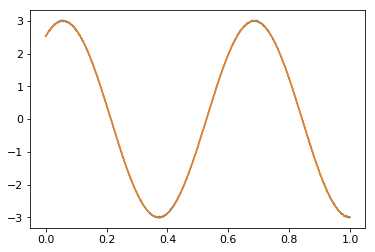

In [117]:
sigma = 0.01
use_mask = False
model_name = "sin"
set_scales()
# results_sin, hessians_sin = monte_carlo_test()
compare(results_sin)

In [ ]:
plot_convergence(results_sin)
figure(); plot_hist(results_sin)
figure(); hessian_var_hist(hessians_sin, results_sin)

In [160]:
array(hessians_exp).mean(axis=0)

array([[  50.4999,   -7.4994,  100.4929],
       [  -7.4994,    2.2498,  -29.9833],
       [ 100.4929,  -29.9833, 1001.    ]])


Var error, %:
[-3.6141 -8.1347 -2.1776]
Cov error, %:
[[ -3.6141  -9.4058 -81.3229]
 [ -9.4058  -8.1347  -7.1333]
 [-81.3229  -7.1333  -2.1776]]


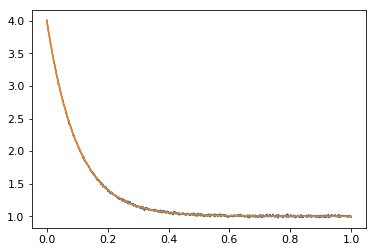

In [159]:
MC_ITER = 2000
sigma = .01
use_mask = False
model_name = "exp"
set_scales()
results_exp, hessians_exp = monte_carlo_test()
compare(results_exp)

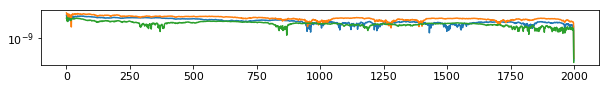

<Figure size 432x288 with 0 Axes>

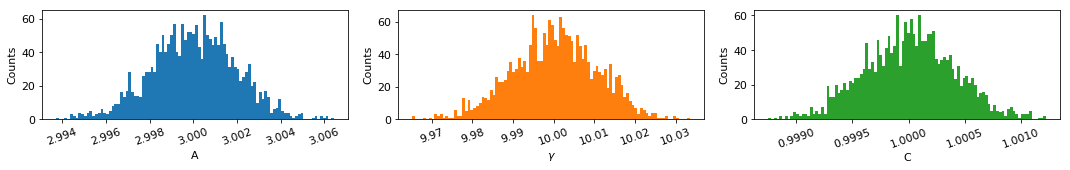

<Figure size 432x288 with 0 Axes>

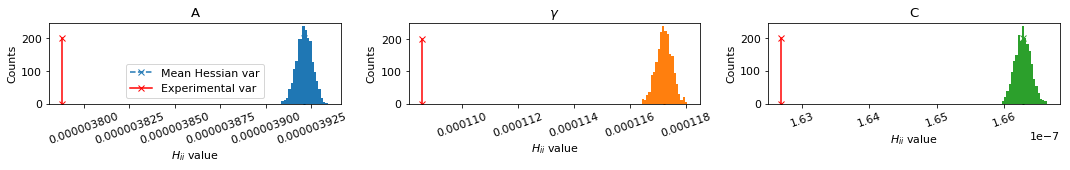

In [161]:
plot_convergence(results_exp)
figure(); plot_hist(results_exp)
figure(); hessian_var_hist(hessians_exp, results_exp)

In [240]:
std(losses)

2.039773357811329e-05

0.00010015083252752567

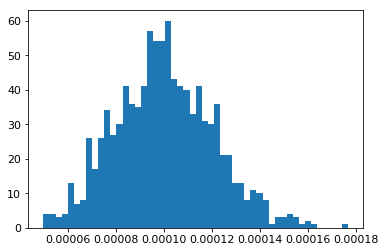

In [239]:
plt.hist(losses, 50)
mean(losses)

In [ ]:
MC_ITER = 10000
NOP = 200
sigma = 0.0001
use_mask = True
model_name = "tr"
set_scales()
results_tr, hessians_tr, losses = monte_carlo_test()
compare(results_tr, True)

In [ ]:
rc("font", size=11)

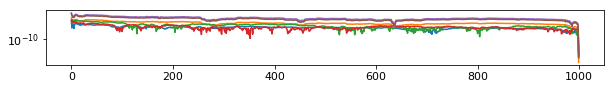

<Figure size 432x288 with 0 Axes>

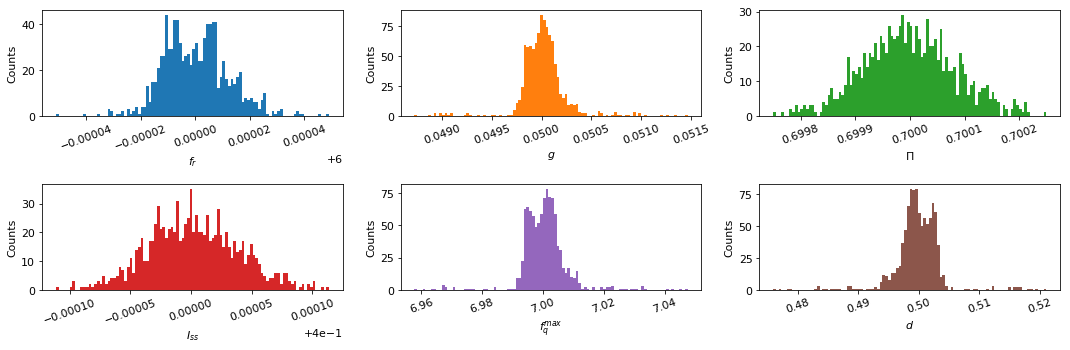

<Figure size 432x288 with 0 Axes>

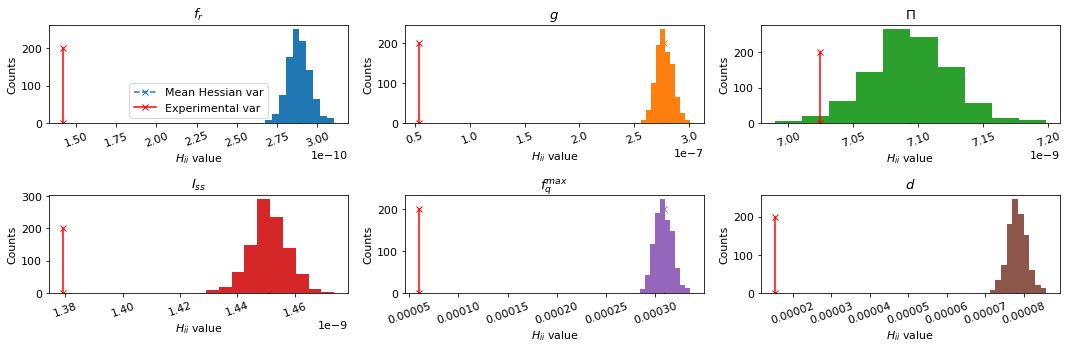

In [242]:
plot_convergence(results_tr)
figure(); plot_hist(results_tr); plt.savefig("../Pictures/MC-test-tr.pdf")
figure(); hessian_var_hist(hessians_tr, results_tr); plt.savefig("../Pictures/MC-test-tr-H.pdf")
# plt.yscale("log")
# plt.xlim(-0.002, 0.002)

In [164]:
set_printoptions(linewidth=150)

In [244]:
(mean(hessians_tr, axis=0))

array([[ 1.8107e+02, -1.1787e+00, -4.8930e-01, -4.8392e+00,  2.0648e+00,  4.3223e+00],
       [-1.1787e+00,  9.6169e+00,  4.0857e-01, -3.9032e-01, -4.9039e-02,  4.7121e-01],
       [-4.8930e-01,  4.0857e-01,  2.0372e+00,  2.3908e+00,  7.1900e-03,  3.6767e-02],
       [-4.8392e+00, -3.9032e-01,  2.3908e+00,  1.0094e+01, -1.2720e-01, -2.8092e-01],
       [ 2.0648e+00, -4.9039e-02,  7.1900e-03, -1.2720e-01,  9.2772e-02,  1.8441e-01],
       [ 4.3223e+00,  4.7121e-01,  3.6767e-02, -2.8092e-01,  1.8441e-01,  4.0079e-01]])

In [245]:
analytic = array([[-1.8106e+02,  1.1768e+00,  4.8924e-01,  4.8388e+00, -2.0657e+00, -4.3246e+00],
       [ 1.1768e+00, -9.6204e+00, -4.0825e-01,  3.9220e-01,  4.9027e-02, -4.7149e-01],
       [ 4.8924e-01, -4.0825e-01, -2.0366e+00, -2.3898e+00, -7.1958e-03, -3.6772e-02],
       [ 4.8388e+00,  3.9220e-01, -2.3898e+00, -1.0092e+01,  1.2731e-01,  2.8128e-01],
       [-2.0657e+00,  4.9027e-02, -7.1958e-03,  1.2731e-01, -9.2824e-02, -1.8455e-01],
       [-4.3246e+00, -4.7149e-01, -3.6772e-02,  2.8128e-01, -1.8455e-01, -4.0115e-01]])

In [246]:
((mean(hessians_tr, axis=0)) + analytic)/analytic*100

array([[-0.0031, -0.1651, -0.0119, -0.0091,  0.0427,  0.0528],
       [-0.1651,  0.036 , -0.0774,  0.4795, -0.0236,  0.0594],
       [-0.0119, -0.0774, -0.0309, -0.0407,  0.0804,  0.0141],
       [-0.0091,  0.4795, -0.0407, -0.0227,  0.0902,  0.128 ],
       [ 0.0427, -0.0236,  0.0804,  0.0902,  0.0565,  0.0752],
       [ 0.0528,  0.0594,  0.0141,  0.128 ,  0.0752,  0.0892]])